# Rejection ABC

This example shows you how to perform rejection ABC on a time series from the stochastic degradation model.

First we generate some data using the suggested parameters for this model

In [3]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load a forward model
model = toy.StochasticDegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 50, 100)
values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior(
    [0.0],
    [0.3]
)

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)

We can visualize the generated data against the expected data below

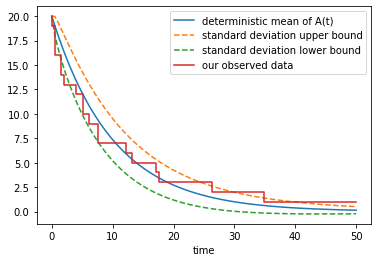

In [4]:
mean = model.mean(real_parameters, times)
variance = model.variance(real_parameters, times)
std_dev = np.sqrt(variance)

plt.plot(times, mean, '-', label = 'deterministic mean of A(t)')
plt.plot(times, mean + std_dev, '--', label = 'standard deviation upper bound')
plt.plot(times, mean - std_dev, '--', label = 'standard deviation lower bound')

plt.step(times, values, label = 'our observed data')
plt.legend(loc = 'upper right')
plt.xlabel('time')
plt.show()

We now create a Sequential ABC Controller, this takes a number of optional parameters but left as default it will carry out the Toni 2019 ABC-SMC sampling algorithm

In [5]:
abc = pints.SequentialABCController(error_measure, log_prior)

In [6]:
# set initial threshold
abc.set_initial_threshold(4)

# set cooling schedule to half temp at every time
abc.set_cooling_schedule(0.25)

# set cooling limit to stop when we would only cool by 0.5
abc.set_cooling_limit(0.1)

# set target number of samples
abc.set_n_target(1000)

# set max number of iterations
abc.set_max_iterations(1000000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print('Done!')

Using Rejection ABC
Running in sequential mode.
Time 0: 1000 samples found at threshold 4 within 1249 evals
Time 1: 1000 samples found at threshold 3.0 within 1636 evals
Time 2: 1000 samples found at threshold 2.25 within 2466 evals
Time 3: 1000 samples found at threshold 1.6875 within 4044 evals
Time 4: 1000 samples found at threshold 1.265625 within 11816 evals
Time 5: 1000 samples found at threshold 0.94921875 within 66289 evals
Hitting max iterations at epsilon=0.889892578125
Time 6: 1000 samples found at threshold 0.889892578125 within 1059616 evals
Eval. Time m:s
1147116  31:52.4
Sampling Complete
Done!


We can then see how our series of intermediate distributions did at approximating the actual parameters by plotting them as histograms

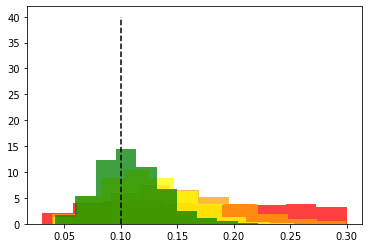

In [7]:
kwargs = dict(alpha=0.75, density=True, stacked=True)
plt.hist([x[0] for x in samples[0][:]], color="red", **kwargs)
plt.hist([x[0] for x in samples[1][:]], color="orange", **kwargs)
plt.hist([x[0] for x in samples[2][:]], color="yellow", **kwargs)
plt.hist([x[0] for x in samples[3][:]], color="green", **kwargs)

plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=40)
plt.show()

_or if you have seaborn installed we can see a prettier version here_

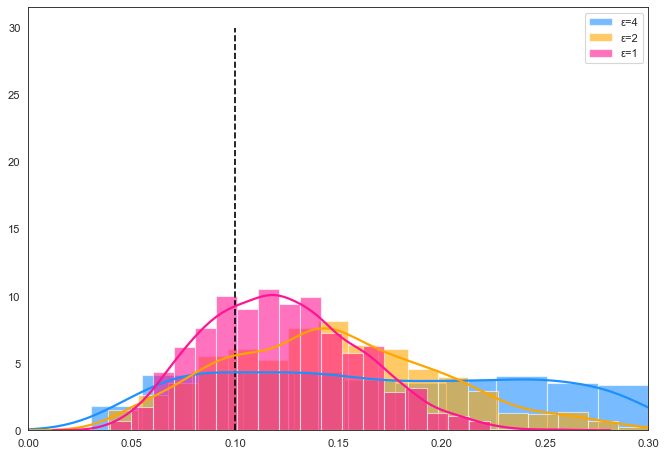

In [8]:
sns.set_style("white")
# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi=80)
sns.distplot([x[0] for x in samples[0][:]], color="dodgerblue", label="ε=4", **kwargs)
sns.distplot([x[0] for x in samples[1][:]], color="orange", label="ε=2", **kwargs)
sns.distplot([x[0] for x in samples[2][:]], color="deeppink", label="ε=1", **kwargs)
plt.xlim(0,0.3)
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=30)
plt.legend();

Now we can compare the recovered parameters to the real parameters used to generate this data

Observed params: [0.09403806]
Actual params: [0.1]


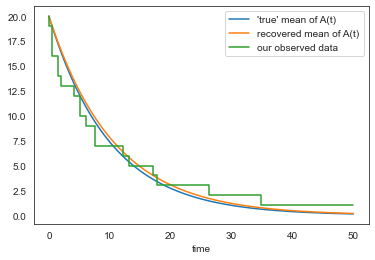

In [9]:
import statistics
observed_k = statistics.median(samples[len(samples)-2][:])
print("Observed params: " + str(observed_k))
print("Actual params: " + str(model.suggested_parameters()))
observed_mean = model.mean(observed_k, times)
true_mean = model.mean(model.suggested_parameters(),times)

plt.plot(times, true_mean, '-', label = "'true' mean of A(t)")
plt.plot(times, observed_mean, '-', label = 'recovered mean of A(t)')
plt.step(times, values, label = 'our observed data')
plt.legend(loc = 'upper right')
plt.xlabel('time')
plt.show()

Compare this to using normal ABC-Rejection

In [11]:
abc = pints.ABCController(error_measure, log_prior, pints.RejectionABC)
# set threshold
abc.sampler().set_threshold(0.889892578125)

# set target number of samples
abc.set_n_target(1000)
# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print('Done!')

Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     43     0.023255814      0:00.0
2     59     0.0338983051     0:00.0
3     132    0.0227272727     0:00.1
20    2702   0.0074019245     0:00.9
40    6772   0.00590667454    0:02.0
60    12883  0.00465730032    0:03.7
80    19164  0.00417449384    0:05.4
100   23368  0.00427935638    0:06.6
120   28786  0.00416869311    0:08.1
140   33087  0.00423126908    0:09.3
160   35834  0.00446503321    0:10.0
180   41618  0.00432505166    0:12.2
200   45786  0.00436814747    0:13.4
220   49112  0.00447955693    0:14.4
240   54200  0.00442804428    0:16.0
260   59058  0.00440245183    0:17.5
280   63609  0.00440189281    0:18.8
300   68906  0.00435375729    0:20.4
320   74628  0.00428793482    0:22.1
340   79773  0.00426209369    0:23.8
360   84386  0.00426611049    0:25.2
380   88583  0.00428976214    0:26.5
400   93211  0.00429133901    0:27.9
420   96188  0.00436644904    0:28.9
440   100762  0.00436672555

In [ ]:
plt.hist(samples[:,0], color="blue")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=50)
plt.show()